In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC, SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_curve, auc
# from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import pandas as pd
pd.options.mode.chained_assignment = None  # Hide long warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import random
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau

### d100

In [2]:
from nilearn import image, plotting
from atlasreader.atlasreader import read_atlas_peak

"""
available reference atlases
---------------------------
    "aal",
    "aicha",
    "desikan_killiany",
    "destrieux",
    "harvard_oxford",
    "juelich",
    "marsatlas",
    "neuromorphometrics",
    "talairach_ba",
    "talairach_gyrus",
 """

atlas = image.threshold_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz", "99.5%") 
atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)
brain_region = []
print("BRAIN REGIONS:\n--------------")
for atlas_coord in atlas_coords:
    region = read_atlas_peak("harvard_oxford", atlas_coord)
    print(region)
    brain_region += [region]

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data

BRAIN REGIONS:
--------------
[[np.float64(62.0), 'Right_Occipital_Pole']]
[[np.float64(50.0), 'Right_Lateral_Occipital_Cortex_superior_division'], [np.float64(30.0), 'Right_Angular_Gyrus']]
[[np.float64(56.0), 'Right_Lateral_Occipital_Cortex_inferior_division'], [np.float64(14.0), 'Right_Occipital_Pole']]
[[np.float64(54.0), 'Left_Cuneal_Cortex'], [np.float64(9.0), 'Right_Cuneal_Cortex']]
[[np.float64(81.0), 'Left_Supramarginal_Gyrus_anterior_division'], [np.float64(6.0), 'Left_Supramarginal_Gyrus_posterior_division']]
[[np.float64(85.0), 'Right_Lateral_Occipital_Cortex_superior_division']]
[[np.float64(66.

In [3]:
#select the correct region with largest probability given from the library
brain_region = [
    max(inner_list, key=lambda x: x[0])[-1] if inner_list else None for inner_list in brain_region
]
brain_region

['Right_Occipital_Pole',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Right_Lateral_Occipital_Cortex_inferior_division',
 'Left_Cuneal_Cortex',
 'Left_Supramarginal_Gyrus_anterior_division',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Right_Supramarginal_Gyrus_posterior_division',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Right_Precuneous_Cortex',
 'Right_Occipital_Fusiform_Gyrus',
 'Left_Angular_Gyrus',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Left_Precuneous_Cortex',
 'Right_Occipital_Pole',
 'Right_Intracalcarine_Cortex',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Left_Occipital_Pole',
 'Left_Lateral_Occipital_Cortex_superior_division',
 'Left_Postcentral_Gyrus',
 'Left_Superior_Frontal_Gyrus',
 'Right_Supramarginal_Gyrus_anterior_division',
 'Right_Lateral_Occipital_Cortex_superior_division',
 'Left_Occipital_Pole',
 'Lef

In [4]:
open_access_data = pd.read_csv("Behavioral Data/Behavioral_Data.csv")
restricted_data = pd.read_csv("Behavioral Data/RESTRICTED_BEHAVIORAL_DATA.csv")
subject_data = open_access_data.merge(restricted_data, how = 'inner', on = 'Subject')

folder = 'HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2'
brain_files = [f for f in os.listdir(folder) if f.endswith('.txt')]
brain_data = {}

for filename in brain_files:
    subject_id = int(filename[:6])
    file_path = os.path.join(folder, filename)
    subject_brain_data = np.loadtxt(file_path)
    brain_data[subject_id] = subject_brain_data

brain_data_df = pd.DataFrame({
    'Subject': list(brain_data.keys()),
    'Brain_Data': list(brain_data.values())  # (4800, 100) arrays
})
brain_data_df

data = subject_data.merge(brain_data_df, on='Subject', how='inner')

In [5]:
data.shape

(1003, 783)

In [6]:
data["Handedness_Cat"] = data["Handedness"].apply(lambda x: 0 if x < 0 else 1) # 0: left handed, 1: right handed
hand_data = data[["Subject", "Gender", "Race", "Handedness", "Handedness_Cat"]]
hand_data

,Subject,Gender,Race,Handedness,Handedness_Cat
0,100206,M,White,65,1
1,100307,F,White,95,1
2,100408,M,White,55,1
3,100610,M,White,85,1
4,101006,F,Black or African Am.,90,1
...,...,...,...,...,...
998,992673,F,White,70,1
999,992774,M,White,100,1
1000,993675,F,White,85,1
1001,994273,M,White,60,1


Correlation Matrices

In [7]:
correlation_matrix_list = []
for i in range(data.shape[0]):
    person = data["Brain_Data"][i]
    #get matrix
    person_matrix = np.corrcoef(person.T)
    #append to list
    correlation_matrix_list.append(person_matrix)
#append to column
data["correlation_matrix"] = correlation_matrix_list

In [8]:
data["correlation_matrix"]

0       [[1.0, -0.0338191132436591, 0.6320023466487581...
1       [[1.0, -0.05357125566667345, 0.416846676528844...
2       [[1.0, -0.06527209331431859, 0.343919331534949...
3       [[1.0, 0.03483607578914373, 0.2461541961309962...
4       [[1.0, 0.22646218683828628, 0.3200554052820826...
                              ...                        
998     [[1.0, -0.05700951869724855, 0.056421358264344...
999     [[0.9999999999999999, 0.14797456065133022, 0.4...
1000    [[0.9999999999999999, -0.12563798932117914, 0....
1001    [[0.9999999999999999, 0.04063140015289049, 0.5...
1002    [[0.9999999999999999, 0.06446200081694943, 0.3...
Name: correlation_matrix, Length: 1003, dtype: object

In [9]:
threshold = 25
filtered_df = data[(data['Handedness'] > threshold) | (data['Handedness'] < -threshold)]

# Separate into left and right handed
left_handed = filtered_df[filtered_df['Handedness'] < 0]
right_handed = filtered_df[filtered_df['Handedness'] > 0]
print(left_handed.shape, right_handed.shape)

# Determine the number of samples to select from the right-handed data
num_samples = min(len(left_handed), len(right_handed))

# Randomly sample from the right-handed data
right_handed_sample = right_handed.sample(n=num_samples, random_state=42)

# Combine the left and right handed data
combined_df = pd.concat([left_handed, right_handed_sample])

# Optionally shuffle the final dataframe to mix left and right handed samples
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

data = combined_df

(74, 785) (891, 785)


In [10]:
data.shape

(148, 785)

In [11]:
# the function extracts the part of correlation matrix that corresponds to a certain feature (i.e. brain region)
def correlation_matrix_of_feature(target):
    target_index = brain_region.index(target)
    target_row = data['correlation_matrix'].apply(lambda x: x[target_index])
    return target_row

In [12]:
# e.g. partial correlation matrix that only corresponds how "Right_Planum_Temporale" relates to other brain regions
correlation_matrix_of_feature("Right_Planum_Temporale")

0      [-0.05852838839859744, -0.2771755195684755, 0....
1      [0.023841477216844317, -0.10169640976533971, -...
2      [-0.10574005218311691, -0.21963189729352228, 0...
3      [-0.12052199260282918, -0.1512767251662827, 0....
4      [-0.16334919884356872, -0.04940728303878206, 0...
                             ...                        
143    [-0.09564880969747118, -0.39387036127835223, 0...
144    [-0.35225872259128477, -0.08985257051112598, 0...
145    [0.2169866971853295, -0.0683979172709244, 0.14...
146    [-0.15043784287746512, -0.16807410469455106, 0...
147    [0.19588925687656528, -0.2121344576936298, 0.0...
Name: correlation_matrix, Length: 148, dtype: object

In [13]:
feature_data = data[["Handedness", "Handedness_Cat", "correlation_matrix"]]
feature_data['matrix_mean'] = data['correlation_matrix'].apply(lambda x: np.mean(x))
feature_data

,Handedness,Handedness_Cat,correlation_matrix,matrix_mean
0,-60,0,"[[0.9999999999999999, -0.124584169771918, 0.38...",0.014255
1,80,1,"[[1.0, 0.04107824424644302, 0.501427929913601,...",0.016203
2,-85,0,"[[0.9999999999999999, 0.18159601108972254, 0.2...",0.014203
3,60,1,"[[1.0, 0.3134034080310095, 0.23354044749194597...",0.010544
4,-30,0,"[[1.0, -0.02790937334135627, 0.521578924678506...",0.015326
...,...,...,...,...
143,50,1,"[[1.0, 0.12232065321564123, 0.4588435647567206...",0.010556
144,95,1,"[[1.0, 0.0070123636012328575, 0.34287581348135...",0.020480
145,75,1,"[[1.0, 0.10834132970644143, 0.3292648567701953...",0.012010
146,-60,0,"[[1.0, 0.09515577242905168, 0.3357731121560449...",0.012535


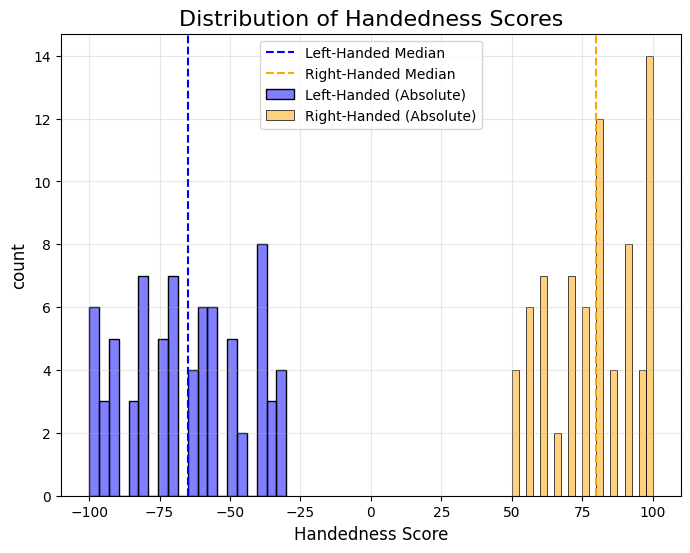

In [14]:
left_handed = data[data['Handedness'] < 0]
right_handed = data[data['Handedness'] > 0]
plt.figure(figsize=(8, 6))
sns.histplot(left_handed['Handedness'], color='blue', label='Left-Handed (Absolute)', kde=False, bins=20, alpha=0.5)
sns.histplot(right_handed['Handedness'], color='orange', label='Right-Handed (Absolute)', kde=False, bins=20, alpha=0.5)


# mark medians
plt.axvline(left_handed['Handedness'].median(), color='blue', linestyle='--', label='Left-Handed Median')
plt.axvline(right_handed['Handedness'].median(), color='orange', linestyle='--', label='Right-Handed Median')

# Labels and title
plt.xlabel('Handedness Score', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('Distribution of Handedness Scores', fontsize=16)
plt.legend()

plt.grid(alpha=0.3)
plt.show()

In [15]:
def correlation_matrix_of_feature(region_name):
    """
    Extracts the correlation matrix of a given brain region from feature_data.
    """
    target_index = brain_region.index(region_name)
    target_row = data['correlation_matrix'].apply(lambda x: x[target_index])
    return target_row

# List of brain regions
features = [
    "Left_Middle_Temporal_Gyrus_posterior_division",
    "Left_Paracingulate_Gyrus",
    "Right_Superior_Parietal_Lobule",
    "Right_Supramarginal_Gyrus_posterior_division",
    "Right_Supramarginal_Gyrus_anterior_division",
    "Right_Thalamus",
    "Right_Putamen",
    "Right_Caudate",
    "Right_Hippocampus",
    "Left_Inferior_Frontal_Gyrus_pars_triangularis",
    "Left_Frontal_Pole",
    "Left_Supramarginal_Gyrus_anterior_division"
]

# Compute correlation matrices for each region
region_correlation_matrices = {region: correlation_matrix_of_feature(region) for region in features}
region_correlation_matrices
print(region_correlation_matrices)


for region, values in region_correlation_matrices.items():
    feature_data[region] = values


{'Left_Middle_Temporal_Gyrus_posterior_division': 0      [-0.15123695821503105, 0.04145961200093252, -0...
1      [-0.09560076996178071, -0.02863435165077892, 0...
2      [-0.010744432195928001, 0.24538351081186116, -...
3      [0.1581416305607244, 0.00912858987580476, 0.09...
4      [-0.20590888203229293, 0.325099187188049, 0.06...
                             ...                        
143    [-0.16915964406807166, -0.06836108768700393, 0...
144    [-0.26472661827100596, 0.337666126945545, -0.0...
145    [0.09881472298091216, 0.3086729352858327, 0.02...
146    [0.008288656896757722, 0.061972122877950175, -...
147    [-0.05618961907713122, -0.018228173170060067, ...
Name: correlation_matrix, Length: 148, dtype: object, 'Left_Paracingulate_Gyrus': 0      [-0.06997615357906925, 0.34588740430202836, -0...
1      [0.22403512413560325, 0.20198682053567546, -0....
2      [0.29017260719262716, 0.3929447215166309, -0.1...
3      [0.38974373776793014, 0.31512970287578024, -0....
4      [0.011

In [16]:
def flatten_features(row):
    """
    Given a single row of the DataFrame, return a 1D numpy array of all features to be used by the model.
    """
    # Flatten the correlation matrix
    corr_mat = np.array(row["correlation_matrix"]).flatten()

    # Extract each brain region's specific correlation values
    region_values = [np.array(row[region]).flatten() for region in features if region in row]

    # Concatenate all features into a single array
    all_features = np.concatenate([corr_mat] + region_values)

    return all_features

### Lasso Regression

In [17]:
X = feature_data.apply(flatten_features, axis = 1)
X = np.vstack(X.values)
y = feature_data['Handedness'].to_numpy()

# # Transform y using Z-score normalization
# scaler_y = StandardScaler()
# y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LASSO regression with cross-validation
lasso = LassoCV(cv=5, alphas=np.logspace(-4, 1, 50)).fit(X_train_scaled, y_train)

# Predict on test set
y_pred = lasso.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimal alpha: {lasso.alpha_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2: {r2:.4f}")

# View selected features
selected_features = np.sum(lasso.coef_ != 0)
print(f"Number of selected features: {selected_features}")

Optimal alpha: 10.0
Mean Squared Error: 5584.6655
R^2: -0.0649
Number of selected features: 73


Since handedness values range from -100 to 100, this error suggests that the model struggles to make precise predictions. Also given the weak R^2, these 80-ish features might not be strongly predictive of handedness.

In [18]:
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted:.2f}")

Actual: 80, Predicted: 1.72
Actual: -30, Predicted: -7.95
Actual: 70, Predicted: 17.17
Actual: 100, Predicted: 1.63
Actual: -80, Predicted: 0.36
Actual: 100, Predicted: 33.95
Actual: -90, Predicted: 5.79
Actual: 100, Predicted: 34.66
Actual: -75, Predicted: 19.25
Actual: 60, Predicted: 30.71


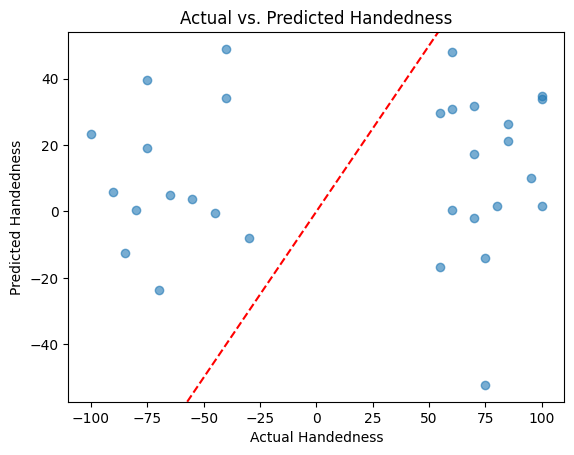

In [19]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Handedness")
plt.ylabel("Predicted Handedness")
plt.title("Actual vs. Predicted Handedness")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect predictions line
plt.show()


---

### Lasso Regression w/ Imbalanced Learn (SMOTE)

1. Randomly select a data point from the minority class
2. Find the K-nearest neighbors of the selected data point
3. Generate new data points on the line segment connecting the selected data point and one of its K-nearest neighbors

SMOTE generates synthetic samples for the minority class instead of simply duplicating existing samples, helping to overcome the overfitting problem that can occur with random oversampling.

**better than random sampling**

dataset size after sampling with SMOTE: X: (364, 11200), y: (364,)
Chunk 1:
  Optimal alpha: 10.0
  Mean Squared Error: 8019.3273
  R^2: -0.2659
  Number of selected features: 57
Chunk 2:
  Optimal alpha: 10.0
  Mean Squared Error: 4209.5502
  R^2: 0.2549
  Number of selected features: 39


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.172e+00, tolerance: 3.122e+00
  model = cd_fast.enet_coordinate_descent(


Chunk 3:
  Optimal alpha: 0.04498432668969444
  Mean Squared Error: 1665.5337
  R^2: 0.2386
  Number of selected features: 49
Chunk 4:
  Optimal alpha: 0.2329951810515372
  Mean Squared Error: 129.2016
  R^2: -0.0345
  Number of selected features: 34
Chunk 5:
  Optimal alpha: 0.29470517025518095
  Mean Squared Error: 57.3661
  R^2: 0.7485
  Number of selected features: 46


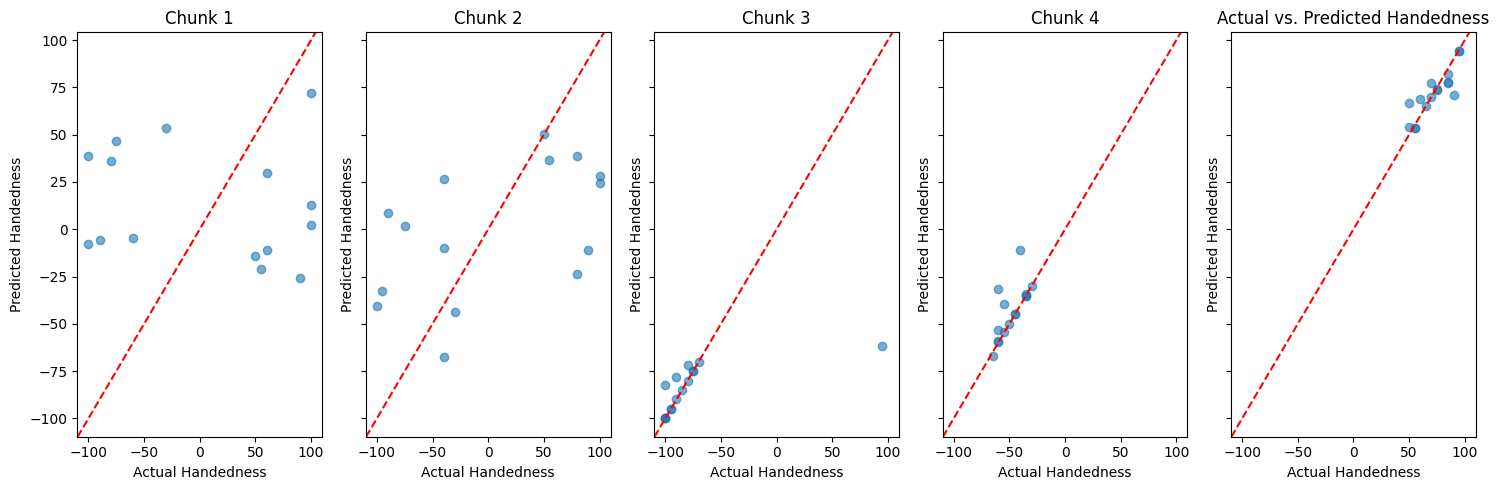

Average MSE across chunks: 2816.1958
Average R^2 across chunks: 0.1883


In [20]:
X = feature_data.apply(flatten_features, axis = 1)
X = np.vstack(X.values)
y = feature_data['Handedness']

smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"dataset size after sampling with SMOTE: X: {X_resampled.shape}, y: {y_resampled.shape}")

# Step 3: Chunking the Dataset into Smaller Batches for Training
num_chunks = 5  # Define number of chunks
chunk_size = len(X_resampled) // num_chunks  # Define chunk size

all_mse = []
all_r2 = []
selected_features_per_chunk = {}

# Create subplots for aggregated plots
fig, axes = plt.subplots(1, num_chunks, figsize=(15, 5), sharex=True, sharey=True)

for i in range(num_chunks):
    # Select a chunk of data
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i != num_chunks - 1 else len(X_resampled)
    
    X_chunk = X_resampled[start_idx:end_idx]
    y_chunk = y_resampled[start_idx:end_idx]
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_chunk, y_chunk, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 4: Train LASSO Regression with Cross-Validation
    lasso = LassoCV(cv=5, alphas=np.logspace(-4, 1, 50)).fit(X_train_scaled, y_train)

    y_pred = lasso.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    selected_features = np.sum(lasso.coef_ != 0)

    all_mse.append(mse)
    all_r2.append(r2)
    selected_features = np.where(lasso.coef_ != 0)[0]
    selected_features_per_chunk[f"Chunk {i+1}"] = selected_features

    # Plot predictions in subplots
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.set_title(f"Chunk {i+1}")
    ax.set_xlabel("Actual Handedness")
    ax.set_ylabel("Predicted Handedness")
    ax.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect predictions line

    print(f"Chunk {i+1}:")
    print(f"  Optimal alpha: {lasso.alpha_}")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R^2: {r2:.4f}")
    print(f"  Number of selected features: {len(selected_features_per_chunk[f'Chunk {i+1}'])}")

plt.title("Actual vs. Predicted Handedness")
plt.tight_layout()
plt.show()

# Final Summary Across All Chunks
print(f"Average MSE across chunks: {np.mean(all_mse):.4f}")
print(f"Average R^2 across chunks: {np.mean(all_r2):.4f}")

LASSO initially over-regularized the model (Chunks 1-2), meaning underfitting.

Chunks 3+ allowed more features, improving predictive performance.

Final chunks balance feature selection & model complexity, achieving best R^2 and lowest MSE.

Balanced α (Chunks 4-5) gives the best performance.



In [21]:
overlap_3_4 = set(selected_features_per_chunk["Chunk 3"]).intersection(selected_features_per_chunk["Chunk 4"])
overlap_4_5 = set(selected_features_per_chunk["Chunk 4"]).intersection(selected_features_per_chunk["Chunk 5"])
overlap_3_5 = set(selected_features_per_chunk["Chunk 3"]).intersection(selected_features_per_chunk["Chunk 5"])

print(f"Overlap between Chunks 3 & 4: {len(overlap_3_4)} features")
print(f"Overlap between Chunks 4 & 5: {len(overlap_4_5)} features")
print(f"Overlap between Chunks 3 & 5: {len(overlap_3_5)} features")

print(overlap_3_4)
print(overlap_4_5)
print(overlap_3_5)


Overlap between Chunks 3 & 4: 0 features
Overlap between Chunks 4 & 5: 1 features
Overlap between Chunks 3 & 5: 1 features
set()
{np.int64(6993)}
{np.int64(6983)}


---

### Logistic Regression

In [22]:
# Prepare feature matrix X and target variable y for classification
X = feature_data.apply(flatten_features, axis=1)
X = np.vstack(X.values)  # Convert to a 2D NumPy array
y = feature_data["Handedness_Cat"].values  # Classification target

# Split dataset into training and testing sets (without SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with Cross-Validation
log_reg = LogisticRegressionCV(cv=5, max_iter=1000, solver='liblinear').fit(X_train_scaled, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["Left-Handed", "Right-Handed"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

Logistic Regression Accuracy: 0.6333

Classification Report:
               precision    recall  f1-score   support

 Left-Handed       0.62      0.67      0.65        15
Right-Handed       0.64      0.60      0.62        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

Confusion Matrix:
 [[10  5]
 [ 6  9]]


~12 correctly classified as Left-Handed, ~3 misclassified as Right-Handed

~11 correctly classified as Right-Handed, ~4 misclassified as Left-Handed

Slight bias towards Left-Handed (higher recall means it captures more Left-Handed instances correctly).

Right-Handed recall is slightly lower, meaning that it misclassifies more Right-Handed cases.


### Logistic Regression w/ imbalanced learn (SMOTE)

In [23]:
# Prepare feature matrix X and target variable y for classification
X = feature_data.apply(flatten_features, axis=1)
X = np.vstack(X.values)
y = feature_data["Handedness_Cat"].values

# Apply SMOTE to balance classes
smote = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with Cross-Validation
log_reg = LogisticRegressionCV(cv=5, max_iter=1000, solver='liblinear').fit(X_train_scaled, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["Left-Handed", "Right-Handed"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)


Logistic Regression Accuracy: 0.7333

Classification Report:
               precision    recall  f1-score   support

 Left-Handed       0.69      0.69      0.69        13
Right-Handed       0.76      0.76      0.76        17

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30

Confusion Matrix:
 [[ 9  4]
 [ 4 13]]


Accuracy drops significantly (from ~75%-80% to 60%-66.67%) after applying SMOTE.

Recall for Left-Handed drops significantly (~0.80 to ~0.5).

Recall for Right-Handed changes slightly (0.73 to 0.71).

Precision for both classes decreases, indicating more false positives. 
* More Left-Handed cases are misclassified as Right-Handed after SMOTE. 
* Right-Handed recall remains almost unchanged (0.73 → 0.71), meaning that **SMOTE doesn't help much in capturing Right-Handed individuals.**

---

### CNN

In [24]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [25]:
# Reshape data for CNN input (assuming X is correlation matrices)
X = np.array(feature_data["correlation_matrix"].tolist())  # Convert list of matrices to array
X_cnn = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Add channel dimension
y_cnn = feature_data["Handedness_Cat"].values  # Classification target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn)

# Define CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (0 = Left, 1 = Right)
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4184 - loss: 0.7409 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5763 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5022 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5778 - loss: 0.6856 - val_accuracy: 0.5333 - val_loss: 0.6965
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6001 - loss: 0.6818 - val_accuracy: 0.5000 - val_loss: 0.6999
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6359 - loss: 0.6638 - val_accuracy: 0.4667 - val_loss: 0.7052
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6424 - loss: 0.6437 - val_accuracy: 0.5000 - val_loss: 0.7062
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6501 - loss: 0.6149 - val_accuracy: 0.5333 - val_loss: 0.7028


In [26]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Left-Handed", "Right-Handed"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Confusion Matrix:
 [[11  4]
 [ 4 11]]

Classification Report:
               precision    recall  f1-score   support

 Left-Handed       0.73      0.73      0.73        15
Right-Handed       0.73      0.73      0.73        15

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30



(May change if re-run)
Many left-handed cases are misclassified (recall is only ~65%), but ~83% of left-handed predictions made is correct. 

The model correctly detects ~85% of right-handed cases, but only 60% of left-handed predictions made is correct. F1-score is better than for left-handed, but precision is relatively lower. 

**Macro & Weighted F1-score = 0.60 → model may be learning patterns from the right-handed class more effectively than the other.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


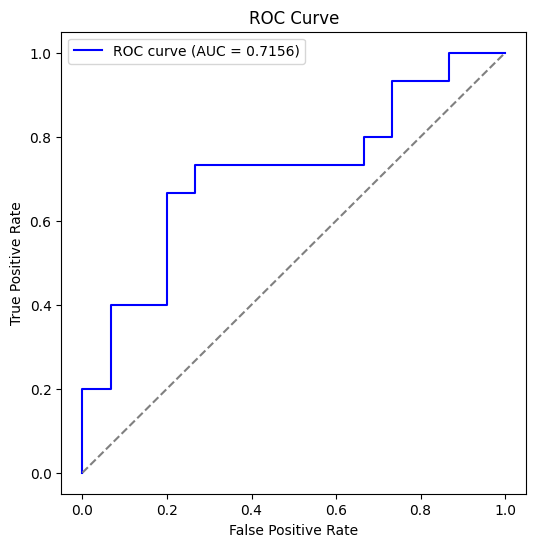

In [27]:
y_prob = model.predict(X_test)  # Get probability scores

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


AUC of ~0.7 means the model is better than random, but still not highly reliable.

### CNN w/ More Weights toward Left-Handed Class

In [28]:
# # Reshape data for CNN input (assuming X is correlation matrices)
# X = np.array(feature_data["correlation_matrix"].tolist())  # Convert list of matrices to array
# X_cnn = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Add channel dimension
# y_cnn = feature_data["Handedness_Cat"].values  # Classification target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn)

# Define CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (0 = Left, 1 = Right)
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights automatically
# class_weights = dict(zip(np.unique(y_train), compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)))
class_weights = {0: 3, 1: 1.0}

# Train Model with dynamically computed class weights
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16, class_weight=class_weights)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4284 - loss: 1.3226 - val_accuracy: 0.5000 - val_loss: 0.9126
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4789 - loss: 1.1997 - val_accuracy: 0.5000 - val_loss: 0.7941
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4789 - loss: 1.1220 - val_accuracy: 0.5000 - val_loss: 0.8865
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4789 - loss: 1.1086 - val_accuracy: 0.5000 - val_loss: 0.8478
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4883 - loss: 1.0757 - val_accuracy: 0.5000 - val_loss: 0.9199
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4789 - loss: 1.1414 - val_accuracy: 0.5000 - val_loss: 0.8137
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4789 - loss: 1.0564 - val_accuracy: 0.5000 - val_loss: 0.8040
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4869 - loss: 0.9944 - val_accuracy: 0.5000 - val_loss: 0.8540
Epoch 9/20


In [29]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Left-Handed", "Right-Handed"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Confusion Matrix:
 [[13  2]
 [ 9  6]]

Classification Report:
               precision    recall  f1-score   support

 Left-Handed       0.59      0.87      0.70        15
Right-Handed       0.75      0.40      0.52        15

    accuracy                           0.63        30
   macro avg       0.67      0.63      0.61        30
weighted avg       0.67      0.63      0.61        30



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


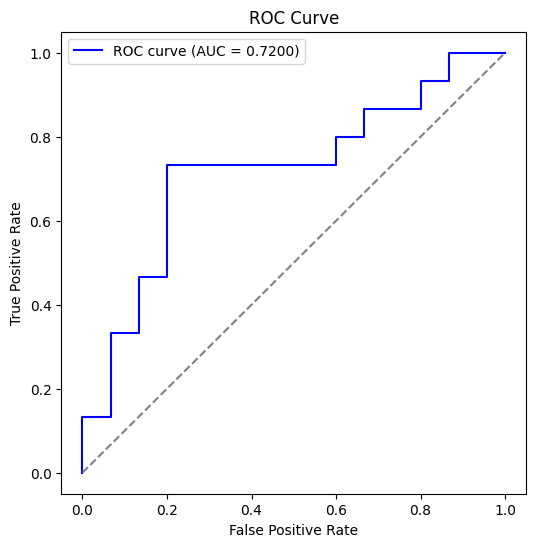

In [30]:
y_prob = model.predict(X_test)  # Get probability scores

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


---

Transforming Handedness

In [31]:
left_handed = data[data['Handedness_Cat'] == 'Left']
right_handed = data[data['Handedness_Cat'] == 'Right']

# Handedness statistics
pd.DataFrame([
    left_handed.describe()['Handedness'], 
    right_handed.describe()['Handedness'], 
    data['Handedness'].describe()
], index=['Left-Handed', 'Right-Handed', 'Overall']).T


,Left-Handed,Right-Handed,Overall
count,0.0,0.0,148.000000
mean,NaN,NaN,6.554054
std,NaN,NaN,74.680388
min,NaN,NaN,-100.000000
25%,NaN,NaN,-65.000000
50%,NaN,NaN,10.000000
75%,NaN,NaN,80.000000
max,NaN,NaN,100.000000


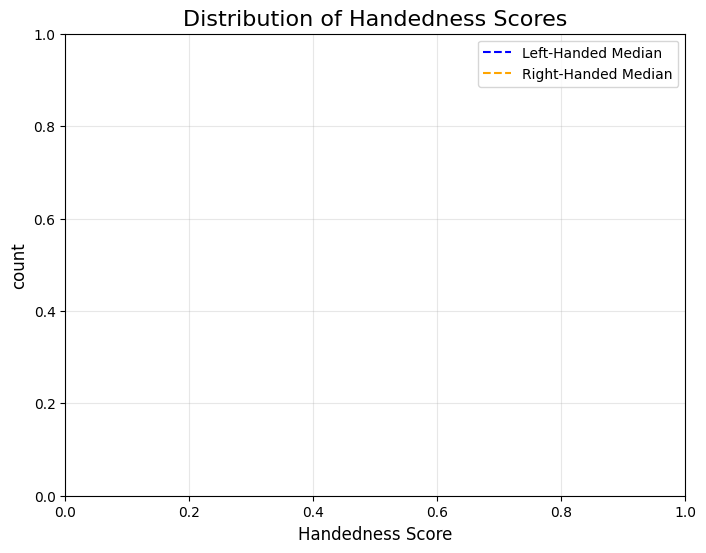

In [32]:
plt.figure(figsize=(8, 6))
sns.histplot(left_handed['Handedness'], color='blue', label='Left-Handed', kde=False, bins=20, alpha=0.5)
sns.histplot(right_handed['Handedness'], color='orange', label='Right-Handed', kde=False, bins=20, alpha=0.5)


# mark medians
plt.axvline(left_handed['Handedness'].median(), color='blue', linestyle='--', label='Left-Handed Median')
plt.axvline(right_handed['Handedness'].median(), color='orange', linestyle='--', label='Right-Handed Median')

# Labels and title
plt.xlabel('Handedness Score', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('Distribution of Handedness Scores', fontsize=16)
plt.legend()

plt.grid(alpha=0.3)
plt.show()

Log tranformation

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/bz/8tkr7qg51_1bcjy3cf4g8fzc0000gn/T/ipykernel_99910/345938297.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


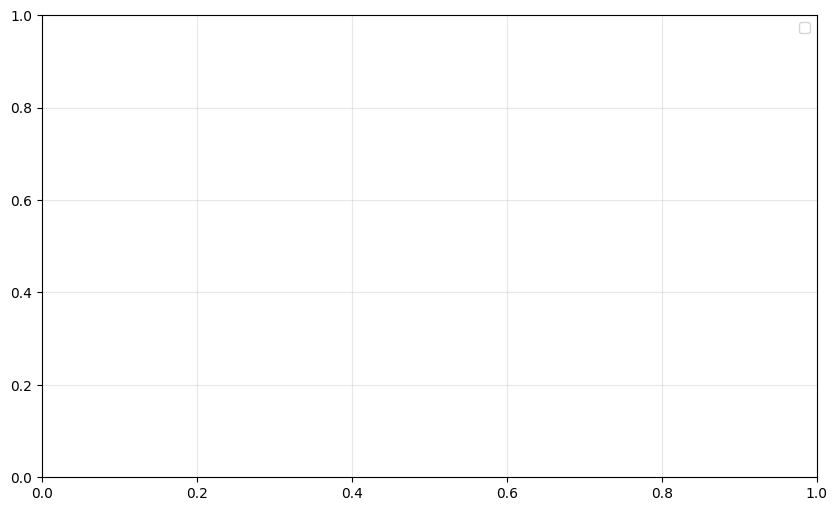

In [33]:
data['log_transformed_handedness'] = np.log10(100-data['Handedness'])

left_handed = data[data['Handedness_Cat'] == 'Left']
right_handed = data[data['Handedness_Cat'] == 'Right']

plt.figure(figsize=(10, 6))
sns.histplot(data=left_handed['log_transformed_handedness'], label='Left-Handed', color='blue', kde=False, bins=20, alpha=0.5, stat='density')
sns.histplot(data=right_handed['log_transformed_handedness'], label='Right-Handed', color='orange', kde=False, bins=20, alpha=0.5, stat='density')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

square root transformation

/var/folders/bz/8tkr7qg51_1bcjy3cf4g8fzc0000gn/T/ipykernel_99910/4275411290.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


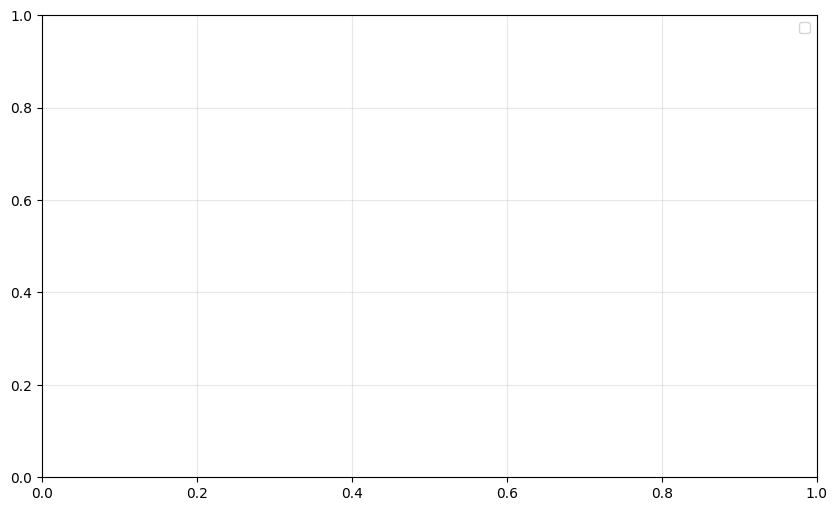

In [34]:
data['sqrt_transformed_handedness'] = data['Handedness'].abs()**0.5

left_handed = data[data['Handedness_Cat'] == 'Left']
right_handed = data[data['Handedness_Cat'] == 'Right']

plt.figure(figsize=(10, 6))
sns.histplot(data=left_handed['sqrt_transformed_handedness'], label='Left-Handed', color='blue', kde=False, bins=20, alpha=0.5, stat='density')
sns.histplot(data=right_handed['sqrt_transformed_handedness'], label='Right-Handed', color='orange', kde=False, bins=20, alpha=0.5, stat='density')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

/var/folders/bz/8tkr7qg51_1bcjy3cf4g8fzc0000gn/T/ipykernel_99910/1017267253.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


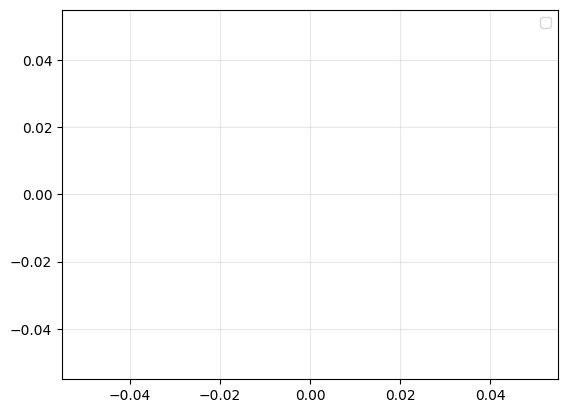

In [35]:
from scipy.stats import zscore

data['zscored_handedness'] = zscore(data['Handedness'])

left_handed = data[data['Handedness_Cat'] == 'Left']
right_handed = data[data['Handedness_Cat'] == 'Right']

sns.histplot(left_handed['zscored_handedness'],label='Left-Handed',bins=10, edgecolor='black', alpha=0.7, stat='density')
sns.histplot(right_handed['zscored_handedness'], label='right-Handed',bins=10, edgecolor='black', alpha=0.7, stat='density')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

/var/folders/bz/8tkr7qg51_1bcjy3cf4g8fzc0000gn/T/ipykernel_99910/3313332115.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


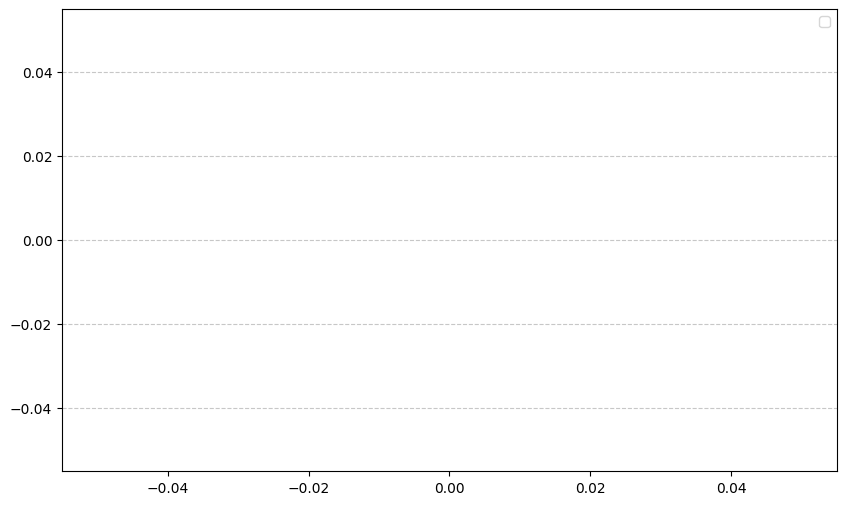

In [36]:
mean_value = left_handed['Handedness'].mean()
std_value = left_handed['Handedness'].std()
left_handed['standardized_handedness'] = (left_handed['Handedness'] - mean_value) / std_value

mean_value = right_handed['Handedness'].mean()
std_value = right_handed['Handedness'].std()
right_handed['standardized_handedness'] = (right_handed['Handedness'] - mean_value) / std_value

plt.figure(figsize=(10, 6))
sns.histplot(left_handed['standardized_handedness'],label='Left-Handed',bins=10, edgecolor='black', alpha=0.7, stat='density')
sns.histplot(right_handed['standardized_handedness'], label='right-Handed',bins=10, edgecolor='black', alpha=0.7, stat='density')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

Symmetric Transformation (Box-Cox)

In [37]:
from scipy.stats import boxcox

data['BoxCox_Handedness'], lambda_ = boxcox(data['Handedness'].abs() + 100)  # Shift to ensure all values are positive
data['BoxCox_Handedness']

0      22580.173480
1      28997.486355
2      30734.827092
3      22580.173480
4      14528.368803
           ...     
143    19688.026537
144    34370.408613
145    27313.538720
146    22580.173480
147    32525.742178
Name: BoxCox_Handedness, Length: 148, dtype: float64

In [38]:
left_handed = data[data['Handedness_Cat'] == 'Left']
right_handed = data[data['Handedness_Cat'] == 'Right']

sns.histplot(left_handed['Handedness_BoxCox'],label='Left-Handed',bins=10, edgecolor='black', alpha=0.7, stat='density')
sns.histplot(right_handed['Handedness_BoxCox'], label='right-Handed',bins=10, edgecolor='black', alpha=0.7, stat='density')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

KeyError: 'Handedness_BoxCox'

In [ ]:
# from scipy.stats import skew, kurtosis

# print("Original Skewness:", skew(data['Handedness']))
# print("Transformed Skewness:", skew(data['log_transformed_handedness']))

# print("Original Kurtosis:", kurtosis(data['Handedness']))
# print("Transformed Kurtosis:", kurtosis(data['log_transformed_handedness']))
